<a href="https://colab.research.google.com/github/musandur/ML-Projects/blob/main/Model_ResNet50_Vgg19_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ResNet50-VGG19 and Model Explainability using LIME** 

****

**Import necessary packages to built our model**

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.initializers import glorot_uniform
from tensorflow.keras import regularizers

import os
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import  Dropout
from glob import glob 
from matplotlib import pyplot as plt
import os


from keras.applications.imagenet_utils import decode_predictions
import skimage.io
import skimage.segmentation
import sklearn
import sklearn.metrics
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from keras.preprocessing.image import load_img
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
import copy
from sklearn.linear_model import LinearRegression


from keras.preprocessing.image import img_to_array

**Build the model: ResNet50 is implemented**

In [2]:
def identity_block(X, f, filters, stage, block):
    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (Height, Width, num_Channels)
    """
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First layer
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second layer
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    #Finally add Skip connection value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [3]:
def convolutional_block(X, f, filters, stage, block, s = 2):

    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, num_hannels)
    """
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)

      
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    # Skip connection 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Finally add skip connection value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X



In [4]:
def ResNet50(input_shape=(150, 150, 3), classes=3):
  """
  Implement of the Resnet50 architecture the model architecture is built in the following way:
  CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK2 -> CONVBLOCK - IDBLOCK*3 -> CONVBLOCK - IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

  """

  # Define the input as a tensor with shape input_shape 
  X_input = Input(input_shape)
  # Zero-Padding 
  X = ZeroPadding2D((3 ,3))(X_input) # (3, 3) padding

  # Stage1
  X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) # 64 filters of 7*7
  X = BatchNormalization(axis=3, name='bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  # Stage2
  X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

  # Stage3 
  X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

  # Stage4
  X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

  # Stage5
  X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

  # AVGPOOL
  X = AveragePooling2D((2, 2), name='avg_pool')(X)

  ### End of the convolutional blocks here
  
  # Output layer
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc'+str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

  # Create model
  model = Model(inputs = X_input, outputs=X, name='ResNet50')

  return model




In [5]:
model = ResNet50((150, 150, 3), 3)

In [6]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
             optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5),
             metrics=['acc'])


In [7]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

**Load and Preprocess Dataset with tf.DAtaset**

In [8]:
# sub_dataset directories
# train cats and dogs directories 
train_dir = '/content/drive/MyDrive/dogs-vs-cats_tutorial/train'
train_cats_dir = '/content/drive/MyDrive/dogs-vs-cats_tutorial/train/cats'
train_dogs_dir = '/content/drive/MyDrive/dogs-vs-cats_tutorial/train/dogs'

# validation cats and dogs directories
val_dir  = '/content/drive/MyDrive/dogs-vs-cats_tutorial/validation'
val_cats_dir = '/content/drive/MyDrive/dogs-vs-cats_tutorial/validation/cats'
val_dogs_dir = '/content/drive/MyDrive/dogs-vs-cats_tutorial/validation/dogs'

# test cats and dogs directories
test_dir = '/content/drive/MyDrive/dogs-vs-cats_tutorial/test'
test_cats_dir = '/content/drive/MyDrive/dogs-vs-cats_tutorial/test/cats'
test_dogs_dir = '/content/drive/MyDrive/dogs-vs-cats_tutorial/test/dogs'


#----Authorise and mount my Google drive---#
#from google.colab import drive
#drive.mount('/content/drive')

#-----Unzip my dataset from GC (Google Colab)----'
#!unzip -uq "/content/drive/MyDrive/dogs-vs-cats_tutorial.zip" -d "/content/drive/MyDrive/"


#----Now we build the data pipeline using tf.data API----#
# training dataset with associated labels
train_cats_data = tf.data.Dataset.list_files(os.path.join(train_cats_dir, '*.jpg'), shuffle=False)
train_cats_data = train_cats_data.map(lambda x: (x, 0))

train_dogs_data = tf.data.Dataset.list_files(os.path.join(train_dogs_dir, '*.jpg'), shuffle=False)
train_dogs_data = train_dogs_data.map(lambda x: (x, 1))

train_data = train_cats_data.concatenate(train_dogs_data)

# validation data set with associated labels
val_cats_data = tf.data.Dataset.list_files(os.path.join(val_cats_dir, '*.jpg'), shuffle=False)
val_cats_data = val_cats_data.map(lambda x: (x, 0))

val_dogs_data = tf.data.Dataset.list_files(os.path.join(val_dogs_dir, '*.jpg'), shuffle=False)
val_dogs_data = val_dogs_data.map(lambda x: (x, 1))

validation_data = val_cats_data.concatenate(val_dogs_data)

# test dataset with associated labels: cat(label=0) and dog(label=1)
test_cats_data = tf.data.Dataset.list_files(os.path.join(test_cats_dir, '*.jpg'), shuffle=False)
test_cats_data = test_cats_data.map(lambda x: (x, 0))

test_dogs_data = tf.data.Dataset.list_files(os.path.join(test_dogs_dir, '*.jpg'), shuffle=False)
test_dogs_data = test_dogs_data.map(lambda x: (x, 1))

test_data = test_cats_data.concatenate(test_dogs_data)


# Data preprocessing before training

# load data
def load(file, label):
  # loading the file into tensor
  image = tf.io.read_file(file)
  # now decode the file to jpeg format
  image = tf.image.decode_jpeg(image)
  # and convert image to tf.float32
  image = tf.cast(image, tf.float32)
  return image, label

# resize all image data to a same size
def resize(image, size):
  return tf.image.resize(image, size)

# normalize all image data 
def normalize(image_data):
  image_data = image_data / 255
  return image_data

def load_and_preprocessing_image_data(imageFile, label):
  image, label = load(imageFile, label)
  image = resize(image, [150, 150])
  image = normalize(image)
  return image, label




#print(list(train_data_processed.as_numpy_iterator())[99][1].shape)

buffer_size1 = tf.data.experimental.cardinality(train_data).numpy()
buffer_size2 = tf.data.experimental.cardinality(validation_data).numpy()
buffer_size3 = tf.data.experimental.cardinality(test_data).numpy()


print(buffer_size1)
num_epochs = 30
# preprocessing, shuffling and batching the datasets
train_data = train_data.shuffle(buffer_size1).map(load_and_preprocessing_image_data,num_parallel_calls=tf.data.AUTOTUNE).batch(20).repeat(num_epochs)
validation_data = validation_data.map(load_and_preprocessing_image_data, num_parallel_calls=tf.data.AUTOTUNE).batch(20).repeat(num_epochs)
test_data = test_data.map(load_and_preprocessing_image_data, num_parallel_calls=tf.data.AUTOTUNE).batch(20).repeat(num_epochs)

# Prefetching delegates decision on the level of parallelism for increasing run time performance: performance optimization 
#tecthnique which allows the preprocessing of the data and model execution to overlap.
train_data = train_data.prefetch(2)
validation_data = validation_data.prefetch(2)
test_data = test_data.prefetch(2)



2000


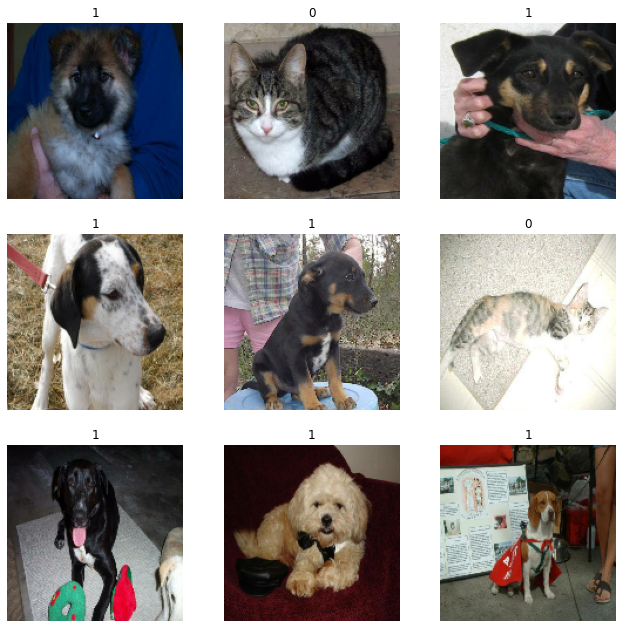

In [9]:
### Plot the shuffled train dataset here #####
plt.figure(figsize=(11, 11))
for images, labels in train_data.take(1):
    #fig, ax = plt.subplots(3, 3)
    for j in range(9):
        image = images[j].numpy()
        #image = image / np.amax(image)
        #image = np.clip(image, 0, 1)
        plt.subplot(3, 3, j+1)
        plt.imshow(image)
        plt.axis('off')
        #plt.show()
        plt.title(labels[j].numpy())
plt.show()

In [10]:
train_data_len = len(glob(os.path.join(train_cats_dir, '*.jpg'))) * 2
val_data_len =  len(glob(os.path.join(val_cats_dir, '*.jpg'))) * 2


In [11]:
history = model.fit(train_data,
                             steps_per_epoch=train_data_len / 20,
                             epochs= num_epochs,
                             validation_data=validation_data,
                             validation_steps=val_data_len / 20)

Epoch 1/30
100/100 [==============================] - 18s 115ms/step - loss: 0.9240 - acc: 0.5245 - val_loss: 0.8204 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 10s 104ms/step - loss: 0.7424 - acc: 0.5757 - val_loss: 0.8524 - val_acc: 0.5000
Epoch 3/30
100/100 [==============================] - 10s 105ms/step - loss: 0.7023 - acc: 0.6118 - val_loss: 0.9067 - val_acc: 0.4980
Epoch 4/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6594 - acc: 0.6507 - val_loss: 1.0177 - val_acc: 0.5000
Epoch 5/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6240 - acc: 0.6536 - val_loss: 0.9032 - val_acc: 0.5140
Epoch 6/30
100/100 [==============================] - 11s 106ms/step - loss: 0.6501 - acc: 0.6479 - val_loss: 0.7333 - val_acc: 0.5680
Epoch 7/30
100/100 [==============================] - 10s 103ms/step - loss: 0.5767 - acc: 0.6941 - val_loss: 0.8114 - val_acc: 0.5670
Epoch 8/30
100/100 [==============================] - 1

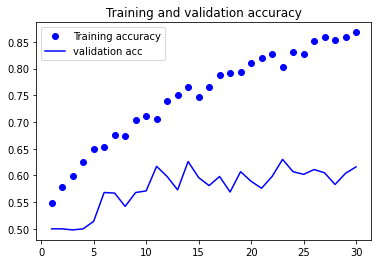

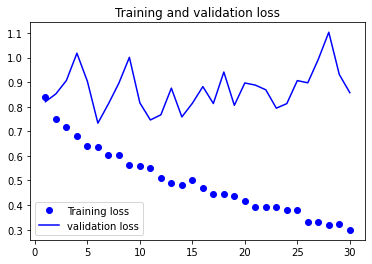

In [12]:
#### Plot the history of the learning 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Above, we have just witnessed overfitting!

**Transfer learning**

In [13]:
model_vgg19 = tf.keras.applications.VGG19(weights='imagenet',
                                         include_top=False,
                                         input_shape=(150, 150, 3))

model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [14]:
model_vgg19.trainable = True
set_trainable = False
for layer in model_vgg19.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False


model_vgg = tf.keras.models.Sequential()
model_vgg.add(model_vgg19)
model_vgg.add(tf.keras.layers.Flatten())
model_vgg.add(Dropout(0.5))
model_vgg.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg.add(tf.keras.layers.Dense(2, activation='softmax'))

model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 22,122,306
Trainable params: 11,537,154
Non-trainable params: 10,585,152
_________________________________________________________________


In [15]:
for variable in model_vgg.trainable_variables:
    print(variable.name)

block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
block5_conv4/kernel:0
block5_conv4/bias:0
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0


In [16]:
model_vgg.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
             optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5),
             metrics=['acc'])


history = model_vgg.fit(train_data,
                             steps_per_epoch=train_data_len / 20,
                             epochs= num_epochs,
                             validation_data=validation_data,
                             validation_steps=val_data_len / 20)

Epoch 1/30
100/100 [==============================] - 9s 76ms/step - loss: 0.7553 - acc: 0.5765 - val_loss: 0.3691 - val_acc: 0.8310
Epoch 2/30
100/100 [==============================] - 8s 76ms/step - loss: 0.3708 - acc: 0.8234 - val_loss: 0.2648 - val_acc: 0.8830
Epoch 3/30
100/100 [==============================] - 8s 76ms/step - loss: 0.2324 - acc: 0.9052 - val_loss: 0.2304 - val_acc: 0.8930
Epoch 4/30
100/100 [==============================] - 8s 76ms/step - loss: 0.1589 - acc: 0.9442 - val_loss: 0.2487 - val_acc: 0.8960
Epoch 5/30
100/100 [==============================] - 8s 76ms/step - loss: 0.1082 - acc: 0.9556 - val_loss: 0.2278 - val_acc: 0.9030
Epoch 6/30
100/100 [==============================] - 8s 77ms/step - loss: 0.0795 - acc: 0.9731 - val_loss: 0.2369 - val_acc: 0.9080
Epoch 7/30
100/100 [==============================] - 7s 74ms/step - loss: 0.0553 - acc: 0.9858 - val_loss: 0.2229 - val_acc: 0.9180
Epoch 8/30
100/100 [==============================] - 7s 73ms/step - 

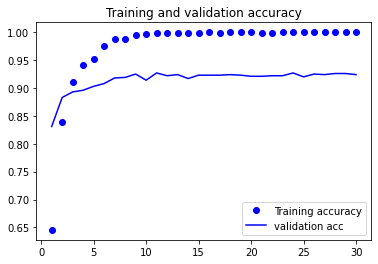

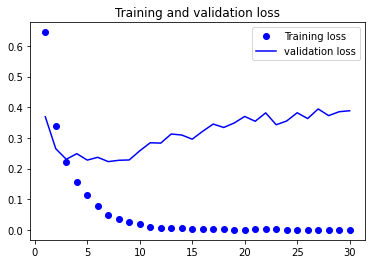

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Transfer learning has mitigated the overfitting issue!

We will thus proceed with predictions and image-based interpretations of model predictions.

In [18]:
test_data_len =  len(glob(os.path.join(test_cats_dir, '*.jpg'))) * 2

result= model_vgg.evaluate(test_data, steps=test_data_len / 20)
print(result)

50/50 [==============================] - 2s 45ms/step - loss: 0.3688 - acc: 0.9270
[0.3688216507434845, 0.9269999861717224]


Random batch index 5:
Accuracy (misclassified/batch_size): 1/20


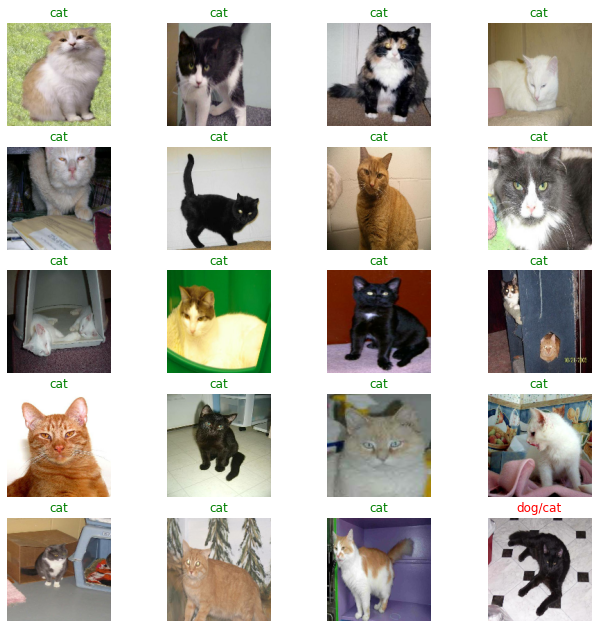

In [19]:
import random
label_to_name = {0: 'cat', 1: 'dog'}
batch_index_cat = random.randint(0, 24)
print('Random batch index {}:'.format(batch_index_cat))
test_data_batch_cat = [list(test_data)[batch_index_cat]]

#for images, labels in test_data.take(1):
for images_cat, labels_cat in test_data_batch_cat:
  predictions_cat = model_vgg(images_cat)

plt.figure(figsize=(11, 11))
k = 0
for i, (imag, y_true, y_pred) in enumerate(zip(images_cat, labels_cat, predictions_cat)):
  plt.subplot(5, 4, i+1)
  if np.argmax(y_pred.numpy()) == y_true.numpy():
    plt.title('{}'.format(label_to_name[y_true.numpy()]), color='green')
  else:
    k +=1
    plt.title('{}/{}'.format(label_to_name[np.argmax(y_pred.numpy())],label_to_name[y_true.numpy()]), color='red')
  
  #plt.subplot(5, 4, i+1)
  plt.imshow(imag.numpy())
  plt.axis('off')
print('Accuracy (misclassified/batch_size): {}/{}'.format(k, 20))

Random batch index 27:
Accuracy (misclassified/batch_size): 2/20


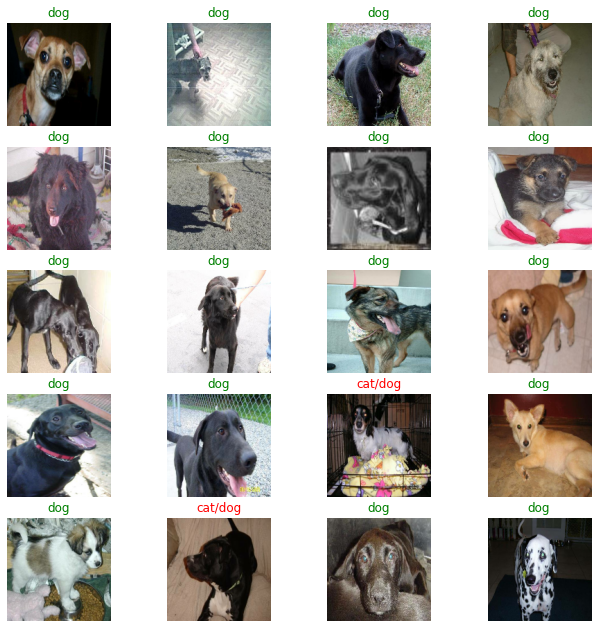

In [20]:
import random
batch_index_dog = random.randint(25, 49)
print('Random batch index {}:'.format(batch_index_dog))
data_batch_dog = [list(test_data)[batch_index_dog]]
for images_dog, labels_dog in data_batch_dog:
  predictions_dog = model_vgg(images_dog)

plt.figure(figsize=(11, 11))
k = 0
for i, (imag, y_true, y_pred) in enumerate(zip(images_dog, labels_dog, predictions_dog)):
  plt.subplot(5, 4, i+1)
  if np.argmax(y_pred.numpy()) == y_true.numpy():
    plt.title('{}'.format(label_to_name[y_true.numpy()]), color='green')
  else:
    k+=1
    plt.title('{}/{}'.format(label_to_name[np.argmax(y_pred.numpy())],label_to_name[y_true.numpy()]), color='red')
  
  #plt.subplot(5, 4, i+1)
  plt.imshow(imag.numpy())
  plt.axis('off')
print('Accuracy (misclassified/batch_size): {}/{}'.format(k, 20))

**Local Interpretable Model-agnostic Explanations**

**Explain Dogs predictions**

In [21]:
batch_index_dog = random.randint(25, 49)
print('Random batch index {}:'.format(batch_index_dog))
data_batch_dog = [list(test_data)[batch_index_dog]]

for images_dog, labels_dog in data_batch_dog:
  predictions_dog = model_vgg(images_dog)
  break

Random batch index 36:


In [22]:
one_dog = random.randint(0, 19)
print(predictions_dog[one_dog].numpy())
top_pred_classes = predictions_dog[one_dog].numpy().argsort()[-1:][::-1]
print(top_pred_classes) 

[9.647047e-21 1.000000e+00]
[1]


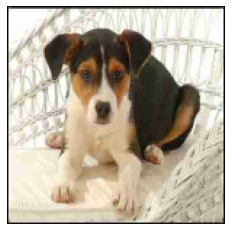

In [23]:
Xi = images_dog[one_dog].numpy()
plt.imshow(Xi)
plt.axis('off')
plt.show()

18


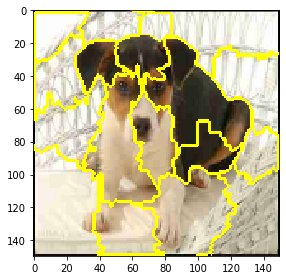

In [24]:
# Generate the superpixels 
segments_quick = quickshift(Xi, kernel_size=4, max_dist=200, ratio=.2)
skimage.io.imshow(mark_boundaries(Xi, segments_quick))
num_superpixels = np.unique(segments_quick).shape[0]
print(num_superpixels)

In [25]:
# Creating the random perturbations of the underlying image
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
print(perturbations.shape)
print(perturbations[0]) #Show example of perturbation

(150, 18)
[0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1]


(150, 150, 3)


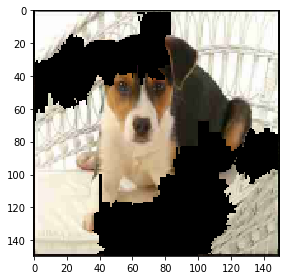

In [26]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

# Dispaly one perturbation example  
skimage.io.imshow(perturb_image(Xi,perturbations[0],segments_quick))
yy = perturb_image(Xi,perturbations[12],segments_quick)
print(yy.shape)

In [27]:
# Predicting the different perturbed images
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,segments_quick)
  pred = model_vgg.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 2)

In [28]:
# computing distances between the original image and the perturbed images
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()

# Computing the corresponding weights
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [29]:
# fit the perturbed data with the linear reg model

from sklearn.linear_model import LinearRegression
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff
print(len(coeff))

18


A dog was predicted, because the model recognises the most important superpixels  displayed below! 

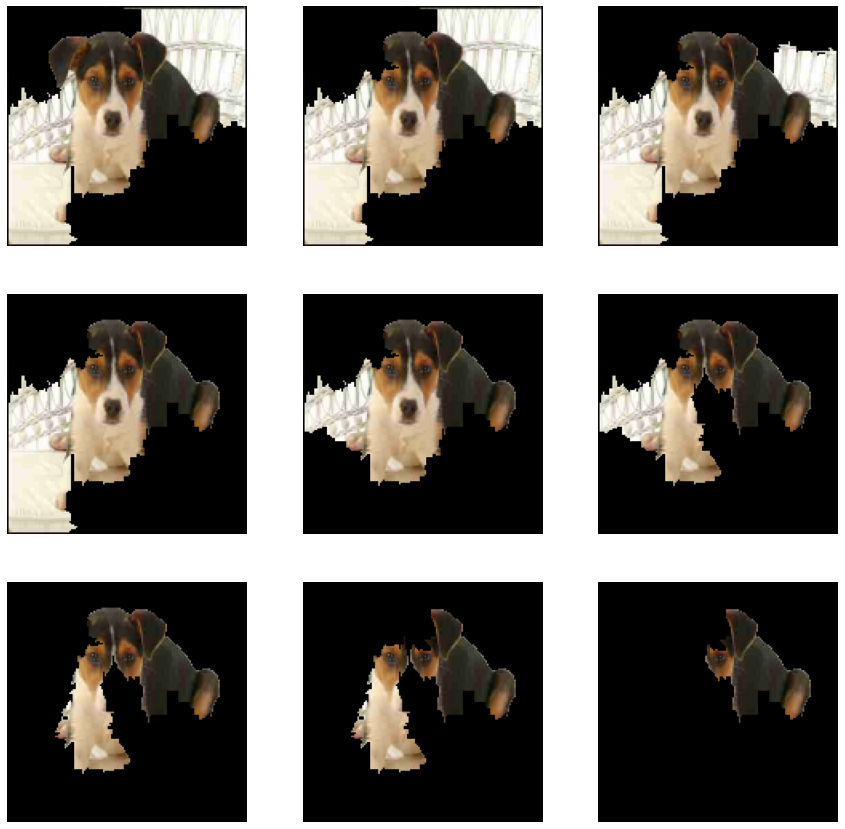

In [30]:
#  Now we sort the coefficients to figure out the superpixels with largest coefficients and ...
#Here we show the most important superpixels 

num_perturbed =9
n_col = 3
n_row = (num_perturbed + n_col - 1) / n_col
plt.figure(figsize=(15, 15))

for num_top_features in range(1, num_perturbed+1)[::-1]:
  top_features = np.argsort(coeff)[-num_top_features:]
  #print(top_features)

  mask = np.zeros(num_superpixels) 
  mask[top_features]= True #Activate top superpixels
  ##skimage.io.imshow(perturb_image(Xi,mask,segments_quick) )


  # now we are going to look at the predictions of the perturbed images via lime
  Xi_p = perturb_image(Xi,mask,segments_quick)
  preds = model_vgg.predict(Xi_p[np.newaxis,:,:,:])
  #yy = decode_predictions(preds[0])#[0] #Top 5 classes
  ttl1 = preds[0][1]
  ttl2 = yy[0][2]*100
  ##print('%s (%.2f%%)'%(yy[0][1], ttl2))

  #decode_predictions(preds)[0] #Top 5 classes

  #plt.figure(figsize=(25, 25))
  plt.subplot(n_row, n_col, 1+num_perturbed -num_top_features)
  plt.imshow(perturb_image(Xi,mask,segments_quick))
  plt.axis('off')

The same model explanation can be implemented for the cat images in the test dataset.